## Reinforcement Learning

Examples in action:

1. Atari: https://www.youtube.com/watch?v=V1eYniJ0Rnk
2. Flappy Bird: https://www.youtube.com/watch?v=79BWQUN_Njc
3. Alpha Go: https://www.youtube.com/watch?v=vFr3K2DORc8 (3:49:00)
4. Dota 2: https://www.youtube.com/watch?v=a7_mnrxFmo0 (25:30)


An introduction to actor critic methods for reinforcement learning: https://hackernoon.com/intuitive-rl-intro-to-advantage-actor-critic-a2c-4ff545978752

In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical


from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## use GPU if one is available - makes it much faster to train
device = "cuda" if torch.cuda.is_available() else "cpu"

Create 16 environments to learn faster. We will work with a simple game as an example: https://gym.openai.com/envs/CartPole-v0/

In [3]:
from common.multiprocessing_env import SubprocVecEnv

num_envs = 16
env_name = "CartPole-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

[2018-09-08 15:48:51,785] Making new env: CartPole-v0
[2018-09-08 15:48:51,787] Making new env: CartPole-v0
[2018-09-08 15:48:51,789] Making new env: CartPole-v0
[2018-09-08 15:48:51,793] Making new env: CartPole-v0
[2018-09-08 15:48:51,796] Making new env: CartPole-v0
[2018-09-08 15:48:51,817] Making new env: CartPole-v0
[2018-09-08 15:48:51,800] Making new env: CartPole-v0
[2018-09-08 15:48:51,817] Making new env: CartPole-v0
[2018-09-08 15:48:51,808] Making new env: CartPole-v0
[2018-09-08 15:48:51,826] Making new env: CartPole-v0
[2018-09-08 15:48:51,826] Making new env: CartPole-v0
[2018-09-08 15:48:51,832] Making new env: CartPole-v0
[2018-09-08 15:48:51,832] Making new env: CartPole-v0
[2018-09-08 15:48:51,848] Making new env: CartPole-v0
[2018-09-08 15:48:51,880] Making new env: CartPole-v0
[2018-09-08 15:48:51,846] Making new env: CartPole-v0
[2018-09-08 15:48:51,840] Making new env: CartPole-v0


## Creat the model

Here we create our actor and our critic.

We take in 4 variables describing the current state of the pole as our sensory output. 

From this, our critic outputs an estimate of how many rewards we expect to get moving forward.

Our actor gives us probabilities for moves. In this case left or right.

The actor and critic make these decisions based on the input.

In [4]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1))
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
            nn.Softmax(dim=1))
        
    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist = Categorical(probs)
        return dist, value

In [5]:
def plot(frame_idx, rewards):
    """
    plot the rewards over time
    """
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    """
    Test the model on an environment
    """
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

## Calculate Returns

This function calculates the discounted rewards. The idea here is that the reward of an action is actually the summation of rewards from that action onward except that we discount rewards which are further in the future. Or place more value on immediate rewards following an action. 

In [6]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        # this is operating on 16 envs at once
        # if mask is false (implying done) then reward for that step should just be the reward for that move. No future.
        R = rewards[step] + R * gamma * masks[step]
        returns.insert(0, R)
    return returns

Set up the models

In [7]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.n

#Hyper params:
hidden_size = 256
lr          = 3e-4
num_steps   = 5

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr)

In [8]:
# Run each env for 20,000 frames
max_frames   = 20000
frame_idx    = 0
test_rewards = []

## Put it all together

For max_frames we make moves.

Num_steps is how many moves we make before the update the model based on the moves and rewards we have accumulated.

For each step, we get the game state and feed it into the model to get the action probabilities and estimated future value. We sample from the action probabilities to make a move and get a reward for that move. A +1 reward if the pole stays up, otherwise 0. 

Once we have gone num_steps we calculate the discounted rewards based on the cumulated rewards the the estimated next_value from the model.

From this we can calculate the advantage, which is the discounted returns minus the estimated values from the critic model.

We tune the critic to minimize the squared value of the advantages.

We tune the actor to prefer moves that put a lot of probability on actions which lead to high advantage. 

We also put entropy in our loss function to encourage exploration.

We then repeat this learning many times to train a model which knows how to play cart pole.

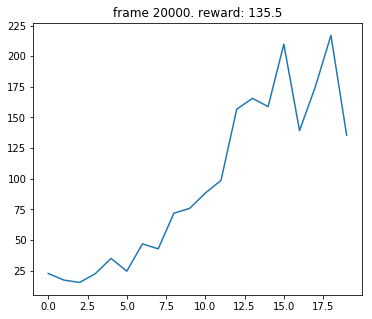

In [9]:
state = envs.reset()

while frame_idx < max_frames:
    log_probs = []
    values = []
    rewards = []
    masks = []
    entropy = 0
    
    for _ in range(num_steps):
        # state is 16 x 4 because 16 envs
        state = torch.FloatTensor(state).to(device)
        # dist and value each have 16 for all envs
        dist, value = model(state)
        
        # have 16 actions
        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())
        
        log_prob = dist.log_prob(action)
        # need to do mean b/c have 16
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        # there are 16 rewards. Need to make it 16x1. Same for masks
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
                
        state = next_state
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            test_rewards.append(np.mean([test_env() for _ in range(10)]))
            plot(frame_idx, test_rewards)
            
    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_returns(next_value, rewards, masks)

    log_probs = torch.cat(log_probs)
    returns = torch.cat(returns).detach()
    values = torch.cat(values)

    advantage = returns - values
    actor_loss = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()
    loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [10]:
test_env(True)

202.0

## Financial Applications: Predicting Crypto Prices

http://www.wildml.com/2018/02/introduction-to-learning-to-trade-with-reinforcement-learning/
    


#### A very simple framework

State -> historical market events like prices

Action Space -> Buy, hold, sell

Reward -> Profit and loss